# PM2.5 Regression: PRSA Aotizhongxin Data (2013-2017)

**UN SDG 3 (Good Health and Well-Being) & UN SDG 11 (Sustainable Cities)**

This notebook predicts continuous PM2.5 air pollution concentration using meteorological and temporal features. All steps are reproducible, memory-efficient, and suitable for Google Colab. Only pandas, numpy, matplotlib, seaborn, and scikit-learn are used.

## 1. Import Required Libraries

All code in this notebook uses only pandas, numpy, matplotlib, seaborn, and scikit-learn. Random seeds are set for reproducibility.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## 2. Load Dataset and Sample 20,000 Rows

The dataset is loaded and a random sample of 20,000 rows is selected to ensure computational efficiency and prevent memory issues in Google Colab. This sampling maintains statistical representativeness while making the analysis feasible for limited-resource environments.

In [15]:
df = pd.read_csv('datasets/PRSA_Data_Aotizhongxin_20130301-20170228.csv')
print('Original shape:', df.shape)
df = df.sample(n=20000, random_state=42)
print('Sampled shape:', df.shape)

Original shape: (35064, 18)
Sampled shape: (20000, 18)


## 3. Exploratory Data Overview

This section provides a quick overview of the sampled data, including the first few rows, data types, summary statistics, target distribution, and missing value counts.

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
6070,6071,2013,11,8,22,162.0,198.0,88.0,110.0,3200.0,NaN,4.4,1015.5,1.8,0.0,ESE,0.1,Aotizhongxin
32600,32601,2016,11,18,8,175.0,240.0,11.0,85.0,3900.0,2.0,6.6,1012.1,2.9,0.0,NE,1.5,Aotizhongxin
8846,8847,2014,3,4,14,7.0,22.0,7.0,9.0,400.0,78.0,9.3,1019.5,-19.8,0.0,WNW,3.9,Aotizhongxin
1483,1484,2013,5,1,19,39.0,116.0,17.0,28.0,500.0,NaN,19.3,1006.6,1.3,0.0,SW,3.1,Aotizhongxin
4219,4220,2013,8,23,19,18.0,49.0,3.0,64.0,500.0,89.0,25.7,1003.2,17.1,0.0,SW,0.7,Aotizhongxin


<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 6070 to 405
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       20000 non-null  int64  
 1   year     20000 non-null  int64  
 2   month    20000 non-null  int64  
 3   day      20000 non-null  int64  
 4   hour     20000 non-null  int64  
 5   PM2.5    19487 non-null  float64
 6   PM10     19606 non-null  float64
 7   SO2      19478 non-null  float64
 8   NO2      19436 non-null  float64
 9   CO       19024 non-null  float64
 10  O3       19026 non-null  float64
 11  TEMP     19990 non-null  float64
 12  PRES     19990 non-null  float64
 13  DEWP     19990 non-null  float64
 14  RAIN     19990 non-null  float64
 15  wd       19944 non-null  object 
 16  WSPM     19993 non-null  float64
 17  station  20000 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 2.9+ MB


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,19487.000000,19606.000000,19478.000000,19436.000000,19024.000000,19026.000000,19990.000000,19990.000000,19990.000000,19990.000000,19993.000000
mean,17569.952800,2014.666200,6.532050,15.685200,11.448000,82.783733,109.526099,17.409166,59.255604,1265.488646,55.893554,13.564986,1011.859823,3.089380,0.067379,1.705757
std,10139.296848,1.178621,3.453313,8.819642,6.906119,82.007106,94.180435,22.937252,37.068545,1217.684238,57.277473,11.414400,10.406952,13.708024,0.854282,1.200968
min,1.000000,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.285600,2.000000,100.000000,0.214200,-16.300000,985.900000,-35.300000,0.000000,0.000000
25%,8758.750000,2014.000000,4.000000,8.000000,5.000000,22.000000,38.000000,3.000000,30.000000,500.000000,8.000000,3.200000,1003.300000,-8.200000,0.000000,0.900000
50%,17582.500000,2015.000000,7.000000,16.000000,11.000000,58.000000,86.000000,9.000000,53.000000,900.000000,42.000000,14.500000,1011.500000,3.700000,0.000000,1.400000
75%,26394.500000,2016.000000,10.000000,23.000000,17.000000,115.000000,155.000000,21.000000,82.000000,1600.000000,82.000000,23.300000,1020.100000,15.600000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,898.000000,984.000000,341.000000,290.000000,10000.000000,423.000000,40.500000,1041.800000,28.500000,40.700000,9.200000


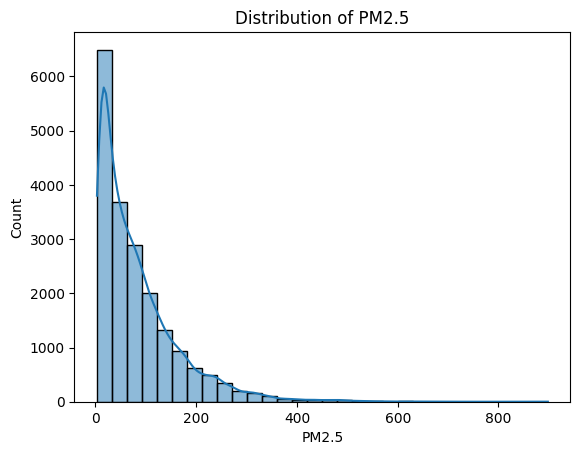

No           0
year         0
month        0
day          0
hour         0
PM2.5      513
PM10       394
SO2        522
NO2        564
CO         976
O3         974
TEMP        10
PRES        10
DEWP        10
RAIN        10
wd          56
WSPM         7
station      0
dtype: int64

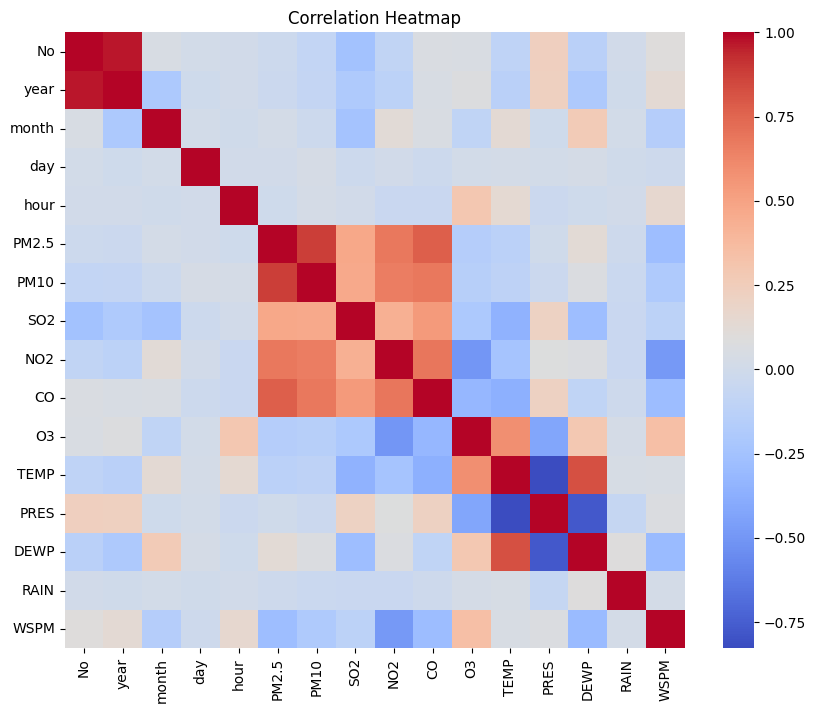

In [16]:
display(df.head())
df.info()
display(df.describe())
sns.histplot(df['PM2.5'].dropna(), bins=30, kde=True)
plt.title('Distribution of PM2.5')
plt.show()
display(df.isnull().sum())
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Handle Missing Values for pm2.5 and Remaining Columns

Missing values in the target column 'pm2.5' are filled using the median. Remaining missing values in other columns are dropped. The final shape and missing value count are displayed.

In [17]:
df['PM2.5'] = df['PM2.5'].fillna(df['PM2.5'].median())
df = df.dropna()
print('Final shape after missing value handling:', df.shape)
print('Total missing values:', df.isnull().sum().sum())

Final shape after missing value handling: (18269, 18)
Total missing values: 0


## 5. One-Hot Encode Categorical Features (Regression)

Object-type (categorical) features are one-hot encoded using pandas get_dummies. The target column 'pm2.5' is separated from the features.

In [19]:
y = df['PM2.5']
X = df.drop('PM2.5', axis=1)
cat_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print('Final feature matrix shape:', X.shape)
print('Feature names:', list(X.columns))

Final feature matrix shape: (18269, 30)
Feature names: ['No', 'year', 'month', 'day', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW']


## 6. Train-Test Split (80/20) (Regression)

The data is split into training and testing sets using an 80/20 split. The shapes of all resulting arrays are printed.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

Train shape: (14615, 30) Test shape: (3654, 30)
y_train shape: (14615,) y_test shape: (3654,)


## 7. Feature Scaling with StandardScaler (Regression)

StandardScaler is used to scale features to zero mean and unit variance, which is important for neural networks and linear regression.

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 8. Build and Evaluate MLPRegressor (Neural Network)

A neural network (MLPRegressor) is trained and evaluated. Metrics include RMSE, R² Score, and cross-validation score.

In [22]:
mlp = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=300, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
mlp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mlp_r2 = r2_score(y_test, y_pred_mlp)
mlp_cv = cross_val_score(mlp, X_train_scaled, y_train, cv=5, scoring='r2')
print('MLPRegressor Results:')
print('RMSE:', mlp_rmse)
print('R2 Score:', mlp_r2)
print('CV Mean R2:', mlp_cv.mean(), 'CV Std:', mlp_cv.std())

MLPRegressor Results:
RMSE: 22.431009296674944
R2 Score: 0.9220273499629211
CV Mean R2: 0.9263938476081334 CV Std: 0.004660176884488423


## 9. Build and Evaluate Linear Regression

A linear regression model is trained and evaluated using the same metrics as above.

In [23]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)
lr_cv = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print('Linear Regression Results:')
print('RMSE:', lr_rmse)
print('R2 Score:', lr_r2)
print('CV Mean R2:', lr_cv.mean(), 'CV Std:', lr_cv.std())

Linear Regression Results:
RMSE: 31.5826077274716
R2 Score: 0.8454245084003148
CV Mean R2: 0.8563613398498191 CV Std: 0.01250216021653861


## 10. Build and Evaluate Random Forest Regressor

A random forest regressor is trained and evaluated using the same metrics as above.

In [24]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
rf_cv = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='r2')
print('Random Forest Regressor Results:')
print('RMSE:', rf_rmse)
print('R2 Score:', rf_r2)
print('CV Mean R2:', rf_cv.mean(), 'CV Std:', rf_cv.std())

Random Forest Regressor Results:
RMSE: 22.013413061732084
R2 Score: 0.9249035461385433
CV Mean R2: 0.9284731948960063 CV Std: 0.004736772571523405


## 11. Model Comparison Table (Regression)

A summary table compares the performance of all three models. A barplot visualizes R² scores for easy comparison.

,Model,RMSE,R2_Score,CV_Mean_R2
0,MLPRegressor,22.431009,0.922027,0.926394
1,Linear Regression,31.582608,0.845425,0.856361
2,Random Forest,22.013413,0.924904,0.928473


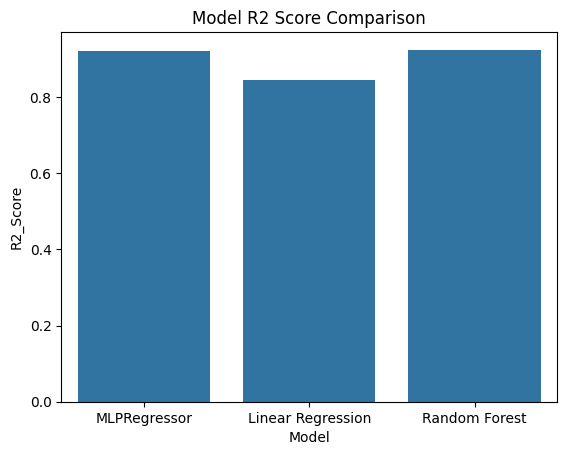

In [25]:
results = pd.DataFrame({
    'Model': ['MLPRegressor', 'Linear Regression', 'Random Forest'],
    'RMSE': [mlp_rmse, lr_rmse, rf_rmse],
    'R2_Score': [mlp_r2, lr_r2, rf_r2],
    'CV_Mean_R2': [mlp_cv.mean(), lr_cv.mean(), rf_cv.mean()]
})
display(results)
sns.barplot(x='Model', y='R2_Score', data=results)
plt.title('Model R2 Score Comparison')
plt.show()

## 12. Hyperparameter Tuning with GridSearchCV (cv=3) (Regression)

GridSearchCV is used to tune hyperparameters for the best-performing model. The best parameters and score are displayed.

In [26]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
gs.fit(X_train_scaled, y_train)
print('Best Parameters:', gs.best_params_)
print('Best CV Score:', gs.best_score_)
best_model = gs.best_estimator_

Best Parameters: {'max_depth': None, 'n_estimators': 200}
Best CV Score: 0.9269371935018405


## 13. Feature Selection using SelectKBest (f_regression)

SelectKBest is used to select the top 10 features based on f_regression. Feature scores are visualized for interpretability.

Selected features: ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'DEWP', 'WSPM', 'wd_NNW', 'wd_NW']


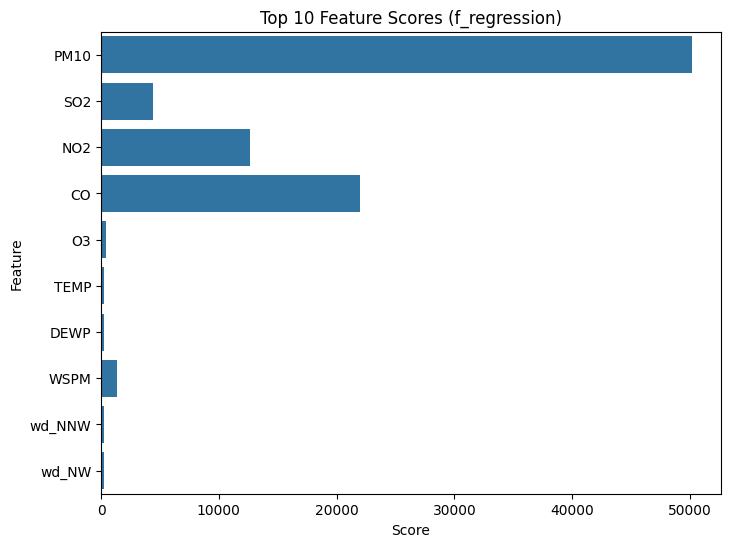

In [27]:
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
selected_features = X_train.columns[selector.get_support()]
print('Selected features:', list(selected_features))
feature_scores = selector.scores_[selector.get_support()]
plt.figure(figsize=(8,6))
sns.barplot(x=feature_scores, y=selected_features)
plt.title('Top 10 Feature Scores (f_regression)')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

## 14. Train Final Model with Best Parameters and Selected Features (Regression)

The best model from GridSearchCV is retrained using only the top 10 features. Predictions are made on the test set.

In [28]:
final_model = best_model
final_model.fit(X_train_selected, y_train)
y_pred_final = final_model.predict(X_test_selected)

## 15. Final Model Evaluation (RMSE, R² Score, Cross-Validation Score)

The final tuned regression model is evaluated on the test set. Results are summarized in a table, and actual vs predicted and residuals plots are provided for report inclusion.

Final Model Results:
RMSE: 23.034262754015632
R2 Score: 0.9177770040369853
CV Mean R2: 0.9180822015908886 CV Std: 0.005735875327927552


,Metric,Score
0,RMSE,23.034263
1,R2 Score,0.917777
2,CV Mean R2,0.918082
3,CV Std,0.005736


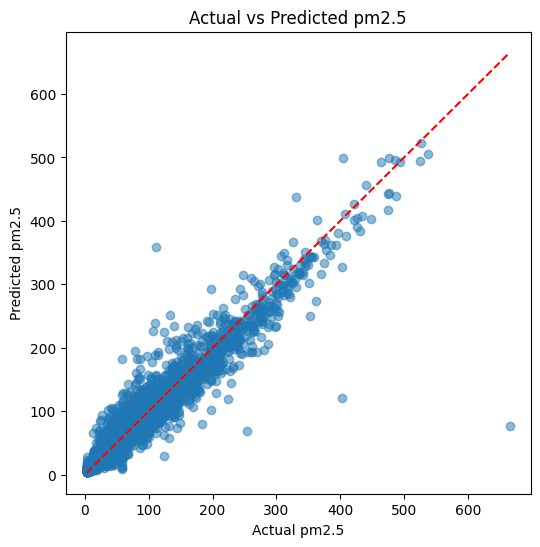

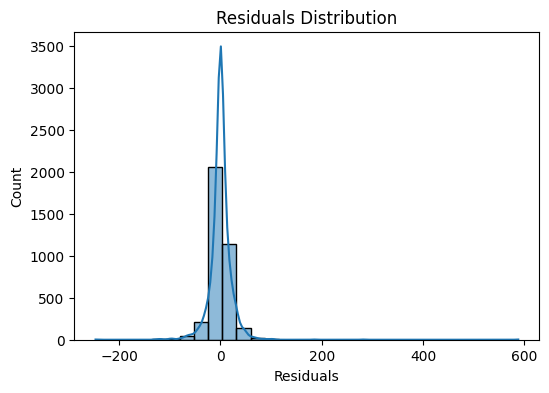

In [29]:
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)
final_cv = cross_val_score(final_model, X_train_selected, y_train, cv=5, scoring='r2')
print('Final Model Results:')
print('RMSE:', final_rmse)
print('R2 Score:', final_r2)
print('CV Mean R2:', final_cv.mean(), 'CV Std:', final_cv.std())
final_results = pd.DataFrame({
    'Metric': ['RMSE', 'R2 Score', 'CV Mean R2', 'CV Std'],
    'Score': [final_rmse, final_r2, final_cv.mean(), final_cv.std()]
})
display(final_results)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.xlabel('Actual pm2.5')
plt.ylabel('Predicted pm2.5')
plt.title('Actual vs Predicted pm2.5')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
plt.figure(figsize=(6,4))
sns.histplot(y_test - y_pred_final, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()

## 16. Train Final Optimized Linear Regression (SelectKBest)

A final optimized Linear Regression model is trained using the top 10 features selected by SelectKBest. Evaluation metrics are reported.

In [30]:
final_lr_reg = LinearRegression()
final_lr_reg.fit(X_train_selected, y_train)
y_pred_lr_final = final_lr_reg.predict(X_test_selected)
final_lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr_final))
final_lr_r2 = r2_score(y_test, y_pred_lr_final)
final_lr_cv = cross_val_score(final_lr_reg, X_train_selected, y_train, cv=5, scoring='r2')
print('Final Optimized Linear Regression Results:')
print('RMSE:', final_lr_rmse)
print('R2 Score:', final_lr_r2)
print('CV Mean R2:', final_lr_cv.mean(), 'CV Std:', final_lr_cv.std())

Final Optimized Linear Regression Results:
RMSE: 31.927729911555726
R2 Score: 0.8420277710889417
CV Mean R2: 0.8531557595258231 CV Std: 0.012661264713958006


## 17. Update Model Comparison Table (5 Models)

The comparison table now includes all five required models: MLPRegressor, Linear Regression (Initial), Random Forest (Initial), Linear Regression (Final), Random Forest (Final).

,Model,RMSE,R2_Score,CV_Mean_R2
0,MLPRegressor,22.431009,0.922027,0.926394
1,Linear Regression (Initial),31.582608,0.845425,0.856361
2,Random Forest (Initial),22.013413,0.924904,0.928473
3,Linear Regression (Final),31.927730,0.842028,0.853156
4,Random Forest (Final),23.034263,0.917777,0.918082


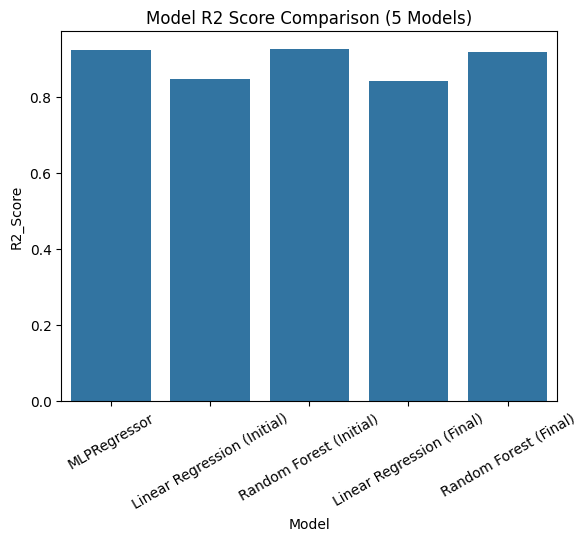

In [31]:
results_5 = pd.DataFrame({
    'Model': [
        'MLPRegressor',
        'Linear Regression (Initial)',
        'Random Forest (Initial)',
        'Linear Regression (Final)',
        'Random Forest (Final)'
    ],
    'RMSE': [mlp_rmse, lr_rmse, rf_rmse, final_lr_rmse, final_rmse],
    'R2_Score': [mlp_r2, lr_r2, rf_r2, final_lr_r2, final_r2],
    'CV_Mean_R2': [mlp_cv.mean(), lr_cv.mean(), rf_cv.mean(), final_lr_cv.mean(), final_cv.mean()]
})
display(results_5)
sns.barplot(x='Model', y='R2_Score', data=results_5)
plt.title('Model R2 Score Comparison (5 Models)')
plt.xticks(rotation=30)
plt.show()